## Load libraries

In [1]:
library(tidyverse) #basis for data manipulation, best practices
library(edgeR) #expression normalization
library(limma) #differential expression
library(reticulate) # Load reticulate for calling the FireCloud Python API
library(bigrquery) # Load biqrquery for interacting with BigQuery
library(EnvStats)
library(xlsx)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: limma


Attaching package: ‘EnvStats’


The following objects are masked from ‘package:stats’:

    predict, predict.lm


The following object is masked from ‘package:base’:

    print.default




## Initialize Workspace Variables

In [2]:
BILLING_PROJECT_ID <- Sys.getenv('GOOGLE_PROJECT')
WORKSPACE_NAMESPACE <- Sys.getenv('WORKSPACE_NAMESPACE')
WORKSPACE_NAME <- Sys.getenv('WORKSPACE_NAME')
WORKSPACE_BUCKET <- Sys.getenv('WORKSPACE_BUCKET')

In [3]:
# Utility routine for printing a shell command before executing it
shell_do <- function(command) {
    print(paste('Executing: ', command))
    system(command, intern = TRUE)
}

In [4]:
gcs_read_file <- function(path) {
    pipe(str_glue('gsutil -u {BILLING_PROJECT_ID} cat {path}'))
}

In [104]:
#Sample metadata
samplemetaPath <- file.path({WORKSPACE_BUCKET}, 'sample_meta_white_BF_cohort_final_PDD_PDMCI_PDNC.csv')
tmp <- gcs_read_file(samplemetaPath)

sample_meta <- read.csv(tmp,header=TRUE)

In [105]:
colnames(sample_meta)

[1] "X"                              "participant_id"                
 [3] "GUID"                           "visit_month"                   
 [5] "sample_id"                      "PCT_USABLE_BASES"              
 [7] "Plate"                          "STRAND_BALANCE"                
 [9] "diagnosis_at_baseline"          "diagnosis_latest"              
[11] "case_control_other_at_baseline" "case_control_other_latest"     
[13] "age_at_baseline"                "age_at_diagnosis"              
[15] "disease_duration"               "sex"                           
[17] "ethnicity"                      "race"                          
[19] "education_level_years"          "moca_total_score"              
[21] "Cognition_phenotype"            "age_baseline_range"            
[23] "belonging_cohort"               "ID_number"

In [106]:
table(sample_meta$age_at_baseline)


53 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 
 1  3  6  4  7  4  5 14  7  3  6 10 13  5 12 12 12  5  7  9  7  1  4  3  2  5 
80 81 82 84 
 2  4  2  1 

In [107]:
table(sample_meta$Cognition_phenotype)


 HCMCI HCnoCI    PDD  PDMCI PDnoCI 
     2     75      2     15     82 

In [110]:
table(sample_meta$Cognition_phenotype, sample_meta$sex)

        
         Female Male
  HCMCI       2    0
  HCnoCI     38   37
  PDD         0    2
  PDMCI       4   11
  PDnoCI     33   49

Choose sex and age of interest

In [108]:
str(sample_meta)

'data.frame':	176 obs. of  24 variables:
 $ X                             : int  0 1 2 3 4 6 7 9 10 11 ...
 $ participant_id                : chr  "BF-1001" "BF-1002" "BF-1003" "BF-1004" ...
 $ GUID                          : chr  "PDNW781VHY" "PDCB969UGG" "PDLW805AHT" "PDKW284DYW" ...
 $ visit_month                   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sample_id                     : chr  "BF-1001-SVM0_5T1" "BF-1002-SVM0_5T1" "BF-1003-SVM0_5T1" "BF-1004-SVM0_5T1" ...
 $ PCT_USABLE_BASES              : num  0.38 0.205 0.252 0.269 0.32 ...
 $ Plate                         : chr  "P341" "P341" "P341" "P341" ...
 $ STRAND_BALANCE                : num  0.628 0.751 0.714 0.675 0.595 ...
 $ diagnosis_at_baseline         : chr  "No PD Nor Other Neurological Disorder" "Idiopathic PD" "Idiopathic PD" "Idiopathic PD" ...
 $ diagnosis_latest              : chr  "No PD Nor Other Neurological Disorder" "Idiopathic PD" "Idiopathic PD" "Idiopathic PD" ...
 $ case_control_other_at_baseline: chr  "Contro

In [109]:
table(sample_meta$sex)


Female   Male 
    77     99 

In [14]:
#Transcriptomics count data
rnaPath <- file.path({WORKSPACE_BUCKET}, 'matrix.featureCounts.tsv')

In [15]:
tmp <- gcs_read_file(rnaPath)

In [16]:
countTable <- read.table(file=tmp, header=TRUE, sep="\t", check.names=FALSE, row.names="Geneid")

In [17]:
#passingGenesAnno
annoPath <- file.path({WORKSPACE_BUCKET}, 'passingGenesAnno.csv')
tmp <- gcs_read_file(annoPath)
filtGenes <- read.csv(tmp,header=TRUE)

In [18]:
dim(countTable)
head(countTable[,c(1:10)])

[1] 58780  8461

,PP-3867-SVM6T1,PD-PDMZ724XCN-SVM18T1,PP-60044-SVM24T1,PP-3604-SVM12T1,PP-3522-SVM12T1,PP-50572-SVM12T1,PD-PDCT406CN9-SVM12T1,PP-3071-SVM12T1,PP-3815-BLM0T1,PD-PDDE532JGE-SVM12T1
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000242268.2,1,0,3,0,1,0,1,0,0,1
ENSG00000259041.1,0,0,0,0,0,0,1,0,0,0
ENSG00000207641.1,0,0,0,0,0,0,0,0,0,0
ENSG00000270112.3,0,0,2,7,1,2,27,2,1,2
ENSG00000280143.1,6,9,38,6,27,13,18,26,19,11
ENSG00000269416.5,0,1,1,1,4,0,8,0,0,0


In [19]:
dim(filtGenes)
head(filtGenes)

[1] 2742017       8

,X,gene_id,gene_name,gene_type,seqname,start,end,strand
,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>
1,0,ENSG00000223972.5,DDX11L1,transcribed_unprocessed_pseudogene,chr1,11869,14409,+
2,1,ENSG00000223972.5,DDX11L1,transcribed_unprocessed_pseudogene,chr1,11869,14409,+
3,2,ENSG00000223972.5,DDX11L1,transcribed_unprocessed_pseudogene,chr1,11869,12227,+
4,3,ENSG00000223972.5,DDX11L1,transcribed_unprocessed_pseudogene,chr1,12613,12721,+
5,4,ENSG00000223972.5,DDX11L1,transcribed_unprocessed_pseudogene,chr1,13221,14409,+
6,5,ENSG00000223972.5,DDX11L1,transcribed_unprocessed_pseudogene,chr1,12010,13670,+


In [20]:
countTable.back <- countTable

In [21]:
countTable <- countTable[rownames(countTable) %in% filtGenes$gene_id,]
dim(countTable)

[1] 58721  8461

In [111]:
#Subset sample data to case control only, match count table to sample table
sample_meta.sub <- sample_meta %>%
    filter(Cognition_phenotype == "PDD" | Cognition_phenotype == "PDnoCI") %>%
    mutate(ageBin = factor(cut(age_at_baseline, breaks=c(0, 55, 65, 100),
                             labels = c("under_55", "55_to_65", "over_65"),
                             right = FALSE,
                             include.lowest = T),
                         levels = c("under_55", "55_to_65", "over_65")))

In [112]:
str(sample_meta.sub) #the difference in the numbers its because we are only selecting PDD and PDnoCI

'data.frame':	84 obs. of  25 variables:
 $ X                             : int  1 2 3 6 13 14 28 36 37 38 ...
 $ participant_id                : chr  "BF-1002" "BF-1003" "BF-1004" "BF-1008" ...
 $ GUID                          : chr  "PDCB969UGG" "PDLW805AHT" "PDKW284DYW" "PDEA056CRM" ...
 $ visit_month                   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sample_id                     : chr  "BF-1002-SVM0_5T1" "BF-1003-SVM0_5T1" "BF-1004-SVM0_5T1" "BF-1008-SVM0_5T1" ...
 $ PCT_USABLE_BASES              : num  0.205 0.252 0.269 0.172 0.205 ...
 $ Plate                         : chr  "P341" "P341" "P341" "P341" ...
 $ STRAND_BALANCE                : num  0.751 0.714 0.675 0.807 0.794 ...
 $ diagnosis_at_baseline         : chr  "Idiopathic PD" "Idiopathic PD" "Idiopathic PD" "Idiopathic PD" ...
 $ diagnosis_latest              : chr  "Idiopathic PD" "Idiopathic PD" "Idiopathic PD" "Idiopathic PD" ...
 $ case_control_other_at_baseline: chr  "Case" "Case" "Case" "Case" ...
 $ case_control_ot

In [113]:
str(sample_meta)

'data.frame':	176 obs. of  24 variables:
 $ X                             : int  0 1 2 3 4 6 7 9 10 11 ...
 $ participant_id                : chr  "BF-1001" "BF-1002" "BF-1003" "BF-1004" ...
 $ GUID                          : chr  "PDNW781VHY" "PDCB969UGG" "PDLW805AHT" "PDKW284DYW" ...
 $ visit_month                   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sample_id                     : chr  "BF-1001-SVM0_5T1" "BF-1002-SVM0_5T1" "BF-1003-SVM0_5T1" "BF-1004-SVM0_5T1" ...
 $ PCT_USABLE_BASES              : num  0.38 0.205 0.252 0.269 0.32 ...
 $ Plate                         : chr  "P341" "P341" "P341" "P341" ...
 $ STRAND_BALANCE                : num  0.628 0.751 0.714 0.675 0.595 ...
 $ diagnosis_at_baseline         : chr  "No PD Nor Other Neurological Disorder" "Idiopathic PD" "Idiopathic PD" "Idiopathic PD" ...
 $ diagnosis_latest              : chr  "No PD Nor Other Neurological Disorder" "Idiopathic PD" "Idiopathic PD" "Idiopathic PD" ...
 $ case_control_other_at_baseline: chr  "Contro

In [114]:
##Filtering by sex (keeping only males)
sample_meta.sub <- sample_meta.sub[sample_meta.sub$sex=='Male',]

In [115]:
#Here is a summary of the samples we will use for this comparison
table(sample_meta.sub$Cognition_phenotype, sample_meta.sub$sex)
table(sample_meta.sub$Cognition_phenotype, sample_meta.sub$ageBin)

        
         Male
  PDD       2
  PDnoCI   49

        
         under_55 55_to_65 over_65
  PDD           0        0       2
  PDnoCI        0       19      30

In [116]:
library(dplyr)
sample_meta.sub %>% filter(Cognition_phenotype == "PDD") %>% pull(age_at_baseline) %>% mean()
sample_meta.sub %>% filter(Cognition_phenotype == "PDD") %>% pull(age_at_baseline) %>% sd()
sample_meta.sub %>% filter(Cognition_phenotype == "PDnoCI") %>% pull(age_at_baseline) %>% mean()
sample_meta.sub %>% filter(Cognition_phenotype == "PDnoCI") %>% pull(age_at_baseline) %>% sd()

[1] 71.5

[1] 2.12132

[1] 67.42857

[1] 6.538348

In [117]:
#order count table and metadata table to match
countsSub <- countTable[,names(countTable) %in% sort(sample_meta.sub$sample_id)]
dim(countsSub)

[1] 58721    51

In [118]:
i <- match(sample_meta.sub$sample_id, names(countsSub), nomatch = 0)
countsSub <- countsSub[,i]

In [119]:
identical(names(countsSub), sample_meta.sub$sample_id) #double checking

[1] TRUE

In [120]:
sample_meta.sub

,X,participant_id,GUID,visit_month,sample_id,PCT_USABLE_BASES,Plate,STRAND_BALANCE,diagnosis_at_baseline,diagnosis_latest,⋯,sex,ethnicity,race,education_level_years,moca_total_score,Cognition_phenotype,age_baseline_range,belonging_cohort,ID_number,ageBin
,<int>,<chr>,<chr>,<int>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<int>,<fct>
2,2,BF-1003,PDLW805AHT,0,BF-1003-SVM0_5T1,0.251916,P341,0.714203,Idiopathic PD,Idiopathic PD,⋯,Male,Not Hispanic or Latino,White,12-16 years,30,PDnoCI,55_to_65,BF,1003,55_to_65
3,3,BF-1004,PDKW284DYW,0,BF-1004-SVM0_5T1,0.269126,P341,0.675027,Idiopathic PD,Idiopathic PD,⋯,Male,Not Hispanic or Latino,White,12-16 years,28,PDnoCI,55_to_65,BF,1004,55_to_65
5,13,BF-1015,PDDL325JX0,0,BF-1015-SVM0_5T1,0.205056,P341,0.793548,Idiopathic PD,Idiopathic PD,⋯,Male,Not Hispanic or Latino,White,12-16 years,27,PDnoCI,55_to_65,BF,1015,55_to_65
7,28,BF-1032,PDJZ532TZK,0,BF-1032-SVM0_5T1,0.178567,P341,0.785834,Idiopathic PD,Idiopathic PD,⋯,Male,Not Hispanic or Latino,White,Greater than 16 years,18,PDD,above_65,BF,1032,over_65
9,37,BF-1044,PDKG534VMG,0,BF-1044-SVM0_5T1,0.543721,P342,0.518666,Idiopathic PD,Idiopathic PD,⋯,Male,Not Hispanic or Latino,White,Greater than 16 years,26,PDnoCI,above_65,BF,1044,over_65
10,38,BF-1045,PDEZ044TE4,0,BF-1045-SVM0_5T1,0.400889,P342,0.632508,Idiopathic PD,Idiopathic PD,⋯,Male,Not Hispanic or Latino,White,Greater than 16 years,26,PDnoCI,above_65,BF,1045,over_65
11,41,BF-1048,PD_INVBF924PLB,0,BF-1048-SVM0_5T1,0.311984,P342,0.665112,Idiopathic PD,Idiopathic PD,⋯,Male,Not Hispanic or Latino,White,Greater than 16 years,29,PDnoCI,55_to_65,BF,1048,55_to_65
12,43,BF-1051,PDYA912JPR,0,BF-1051-SVM0_5T1,0.428424,P341,0.552939,Idiopathic PD,Idiopathic PD,⋯,Male,Not Hispanic or Latino,White,Greater than 16 years,27,PDnoCI,55_to_65,BF,1051,over_65
13,46,BF-1054,PDTF210PBJ,0,BF-1054-SVM0_5T1,0.217465,P341,0.761710,Idiopathic PD,Idiopathic PD,⋯,Male,Not Hispanic or Latino,White,Greater than 16 years,27,PDnoCI,55_to_65,BF,1054,over_65


In [102]:
##Subsetting just to keep females


In [121]:
str(sample_meta.sub)

'data.frame':	51 obs. of  25 variables:
 $ X                             : int  2 3 13 28 37 38 41 43 46 47 ...
 $ participant_id                : chr  "BF-1003" "BF-1004" "BF-1015" "BF-1032" ...
 $ GUID                          : chr  "PDLW805AHT" "PDKW284DYW" "PDDL325JX0" "PDJZ532TZK" ...
 $ visit_month                   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sample_id                     : chr  "BF-1003-SVM0_5T1" "BF-1004-SVM0_5T1" "BF-1015-SVM0_5T1" "BF-1032-SVM0_5T1" ...
 $ PCT_USABLE_BASES              : num  0.252 0.269 0.205 0.179 0.544 ...
 $ Plate                         : chr  "P341" "P341" "P341" "P341" ...
 $ STRAND_BALANCE                : num  0.714 0.675 0.794 0.786 0.519 ...
 $ diagnosis_at_baseline         : chr  "Idiopathic PD" "Idiopathic PD" "Idiopathic PD" "Idiopathic PD" ...
 $ diagnosis_latest              : chr  "Idiopathic PD" "Idiopathic PD" "Idiopathic PD" "Idiopathic PD" ...
 $ case_control_other_at_baseline: chr  "Case" "Case" "Case" "Case" ...
 $ case_control_

Differential Expression testing with limma

In [123]:
## sample design
case <- factor(gsub("\\+", "", sample_meta.sub$Cognition_phenotype), levels = c("PDD", "PDnoCI"))
age <- factor(sample_meta.sub$ageBin, levels = c("under_55", "55_to_65", "over_65"))
#sex <- factor(sample_meta.sub$sex,
              #levels = c("Male", "Female"))
plate <- factor(sample_meta.sub$Plate)
usableBases <- sample_meta.sub$PCT_USABLE_BASES
strandBalance <- sample_meta.sub$STRAND_BALANCE

In [124]:
case

[1] PDnoCI PDnoCI PDnoCI PDD    PDnoCI PDnoCI PDnoCI PDnoCI PDnoCI PDnoCI
[11] PDnoCI PDnoCI PDnoCI PDnoCI PDnoCI PDnoCI PDnoCI PDnoCI PDnoCI PDnoCI
[21] PDnoCI PDnoCI PDnoCI PDnoCI PDnoCI PDnoCI PDnoCI PDnoCI PDnoCI PDnoCI
[31] PDnoCI PDnoCI PDnoCI PDnoCI PDnoCI PDnoCI PDnoCI PDnoCI PDnoCI PDnoCI
[41] PDnoCI PDD    PDnoCI PDnoCI PDnoCI PDnoCI PDnoCI PDnoCI PDnoCI PDnoCI
[51] PDnoCI
Levels: PDD PDnoCI

In [125]:
plate

[1] P341 P341 P341 P341 P342 P342 P342 P341 P341 P341 P341 P341 P341 P342 P342
[16] P342 P342 P342 P342 P342 P342 P341 P342 P343 P342 P342 P342 P342 P342 P343
[31] P341 P341 P341 P341 P342 P342 P342 P343 P341 P341 P341 P341 P341 P341 P341
[46] P342 P342 P343 P342 P343 P343
Levels: P341 P342 P343

In [126]:
design <- model.matrix(~ 0 + case + plate + usableBases + strandBalance)

In [127]:
design

,casePDD,casePDnoCI,plateP342,plateP343,usableBases,strandBalance
1,0,1,0,0,0.251916,0.714203
2,0,1,0,0,0.269126,0.675027
3,0,1,0,0,0.205056,0.793548
4,1,0,0,0,0.178567,0.785834
5,0,1,1,0,0.543721,0.518666
6,0,1,1,0,0.400889,0.632508
7,0,1,1,0,0.311984,0.665112
8,0,1,0,0,0.428424,0.552939
9,0,1,0,0,0.217465,0.761710
10,0,1,0,0,0.237050,0.757579


In [128]:
colnames(design) <- gsub("case", "", colnames(design))

In [129]:
design

,PDD,PDnoCI,plateP342,plateP343,usableBases,strandBalance
1,0,1,0,0,0.251916,0.714203
2,0,1,0,0,0.269126,0.675027
3,0,1,0,0,0.205056,0.793548
4,1,0,0,0,0.178567,0.785834
5,0,1,1,0,0.543721,0.518666
6,0,1,1,0,0.400889,0.632508
7,0,1,1,0,0.311984,0.665112
8,0,1,0,0,0.428424,0.552939
9,0,1,0,0,0.217465,0.761710
10,0,1,0,0,0.237050,0.757579


In [130]:
contr.matrix <- makeContrasts(
  Case_vs_Control = PDD - PDnoCI,
  levels = colnames(design)
)

In [131]:
contr.matrix

,Case_vs_Control
PDD,1
PDnoCI,-1
plateP342,0
plateP343,0
usableBases,0
strandBalance,0


Pre-filtering and count normalization to counts per million (CPM)

In [132]:
## normalization and filtering in limma
keep <- filterByExpr(countsSub, group = case)
sum(keep) #this is the number of genes we are testing for differential expression

[1] 23263

In [133]:
dge <- DGEList(countsSub[keep,])

In [134]:
dge  <- calcNormFactors(dge) #normalizes, what does it do?

In [135]:
#sample_meta_male_over_65.sub$sex <- as.factor(sample_meta_male_over_65.sub$sex)

In [136]:
#par(mfrow=c(1,2))
#levels(sample_meta_male_over_65.sub$sex) #what is this?
#col.cell <- c("purple","orange")[sample_meta_male_over_65.sub$sex]
#data.frame(sample_meta_male_over_65.sub$sex,col.cell)

In [137]:
#plotMDS(dge,col=col.cell)

In [138]:
#order gene list
genes.anno.Match <- filtGenes[filtGenes$gene_id %in% sort(row.names(dge$counts)),]
dim(genes.anno.Match)

[1] 2230013       8

In [139]:
i <- match(row.names(dge$counts), genes.anno.Match$gene_id, nomatch = 0)

In [140]:
genes.anno.Match <- genes.anno.Match[i,]

In [141]:
genes.anno.Match

,X,gene_id,gene_name,gene_type,seqname,start,end,strand
,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>
1553274,1553273,ENSG00000280143.1,AP000892.3,TEC,chr11,117204967,117210292,+
2400893,2400892,ENSG00000269416.5,LINC01224,lincRNA,chr19,23399233,23416075,-
653470,653469,ENSG00000263642.1,MIR4802,miRNA,chr4,40502040,40502119,-
2157821,2157820,ENSG00000198242.13,RPL23A,protein_coding,chr17,28719393,28724359,+
1767755,1767754,ENSG00000231981.3,RPL7L1P12,processed_pseudogene,chr13,98949719,98950447,-
458779,458778,ENSG00000134108.12,ARL8B,protein_coding,chr3,5122220,5180912,+
1759388,1759387,ENSG00000276644.4,DACH1,protein_coding,chr13,71437966,71867192,-
33611,33610,ENSG00000231105.1,AL031728.1,antisense,chr1,21293290,21299774,+
2430783,2430782,ENSG00000167578.17,RAB4B,protein_coding,chr19,40778216,40796938,+


In [142]:
identical(genes.anno.Match$gene_id, row.names(dge$counts)) #double checking

[1] TRUE

In [143]:
dge$genes <- genes.anno.Match

In [144]:
dim(dge) #where rows are the samples

[1] 23263    51

In [145]:
CPM <- cpm(dge) #used to calculate counts per million (CPM) values for a matrix or data frame of
#normalized counts. CPM values are commonly used to normalize and compare gene expression levels across different samples.

In [146]:
logCPM <- cpm(dge, log = TRUE, prior.count = 3)

In [147]:
cpm_names <- cbind(gene_name=genes.anno.Match$gene_name, CPM) #it was binded the gene name from gene anno and the cpm matrix from
#the count_table matrix. 
head(cpm_names)[1:5,1:5] #when CPM ==0?

,gene_name,BF-1003-SVM0_5T1,BF-1004-SVM0_5T1,BF-1015-SVM0_5T1,BF-1032-SVM0_5T1
ENSG00000280143.1,AP000892.3,0.566477318865705,0.333733234115086,0.374226796607888,0.198601005243144
ENSG00000269416.5,LINC01224,0,0,0,0.066200335081048
ENSG00000263642.1,MIR4802,2.11141546122672,3.78230998663764,0.748453593215777,1.78740904718829
ENSG00000198242.13,RPL23A,371.763614990139,265.151054504436,372.605147155921,340.071121311343
ENSG00000231981.3,RPL7L1P12,1.49344020428231,0.834333085287715,1.74639171750348,1.19160603145886


In [148]:
dim(cpm_names) #just one column more: gene_name

[1] 23263    52

In [149]:
cpm_names_dist <- distinct(as.data.frame(cpm_names), gene_name, .keep_all = TRUE)
head(cpm_names_dist)[1:5,1:5]
dim(cpm_names)
dim(cpm_names_dist)

,gene_name,BF-1003-SVM0_5T1,BF-1004-SVM0_5T1,BF-1015-SVM0_5T1,BF-1032-SVM0_5T1
,<chr>,<chr>,<chr>,<chr>,<chr>
ENSG00000280143.1,AP000892.3,0.566477318865705,0.333733234115086,0.374226796607888,0.198601005243144
ENSG00000269416.5,LINC01224,0,0,0,0.066200335081048
ENSG00000263642.1,MIR4802,2.11141546122672,3.78230998663764,0.748453593215777,1.78740904718829
ENSG00000198242.13,RPL23A,371.763614990139,265.151054504436,372.605147155921,340.071121311343
ENSG00000231981.3,RPL7L1P12,1.49344020428231,0.834333085287715,1.74639171750348,1.19160603145886


[1] 23263    52

[1] 23065    52

Limma voom, fit, and eBayes

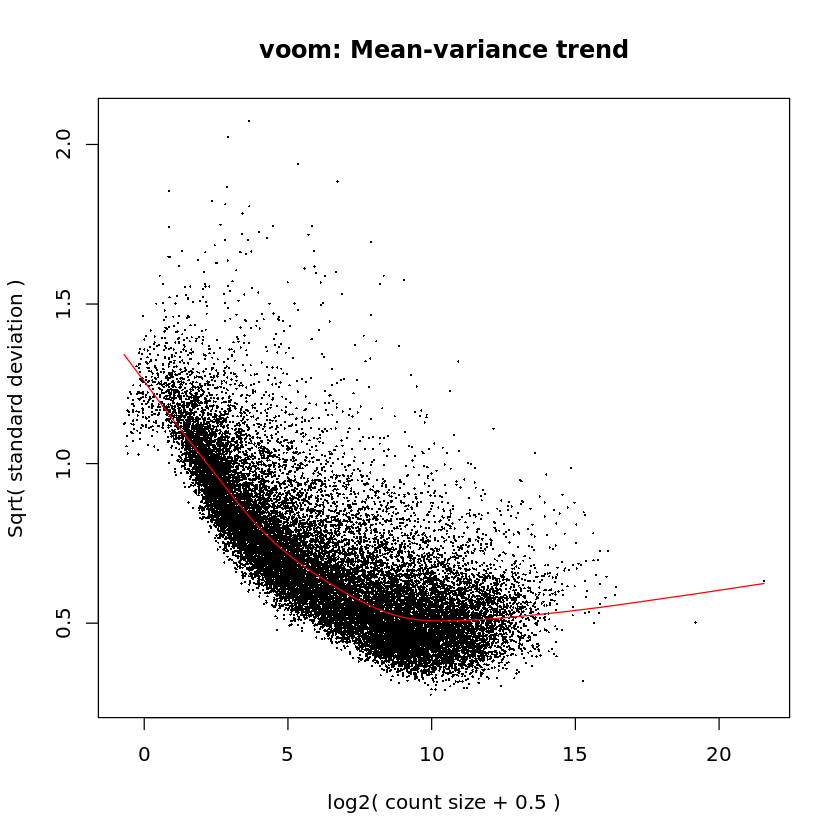

In [150]:
#Transform count data to log2-counts per million (logCPM), estimate the mean-variance relationship and use this to compute appropriate observational-level weights.
#The data are then ready for linear modelling.
v <- voom(dge, design, plot=TRUE) #check voom plot for curve to see if we need to do more filtering
# voom is used to transform RNA-seq count data into log-counts-per-million (logCPM) values suitable for linear modeling and differential expression analysis.

#design: A design matrix or model matrix specifying the experimental design and contrasts of interest for differential expression analysis.

In [151]:
#compute linear model fit for each gene, given our design and the results from voom
vfit <- lmFit(v, design)
vfit.con1 <- contrasts.fit(vfit, contrasts=contr.matrix) 
#The lmFit() function is a part of the limma package in R.
#It is used for fitting linear models to gene expression data, particularly for 
#differential expression analysis in microarray and RNA-seq experiments.

The eBayes() function applies an empirical Bayes method to estimate the overall distribution of gene-specific variances. It shrinks the estimated gene-specific variances towards a common value, resulting in more stable and moderated estimates. This shrinkage improves the accuracy of statistical inference, especially in cases where the number of samples is small.

In [152]:
#Given a linear model fit, compute moderated t-statistics, moderated F-statistic, and log-odds of differential expression by empirical Bayes moderation of the standard errors towards a common value
efit <- eBayes(vfit.con1)

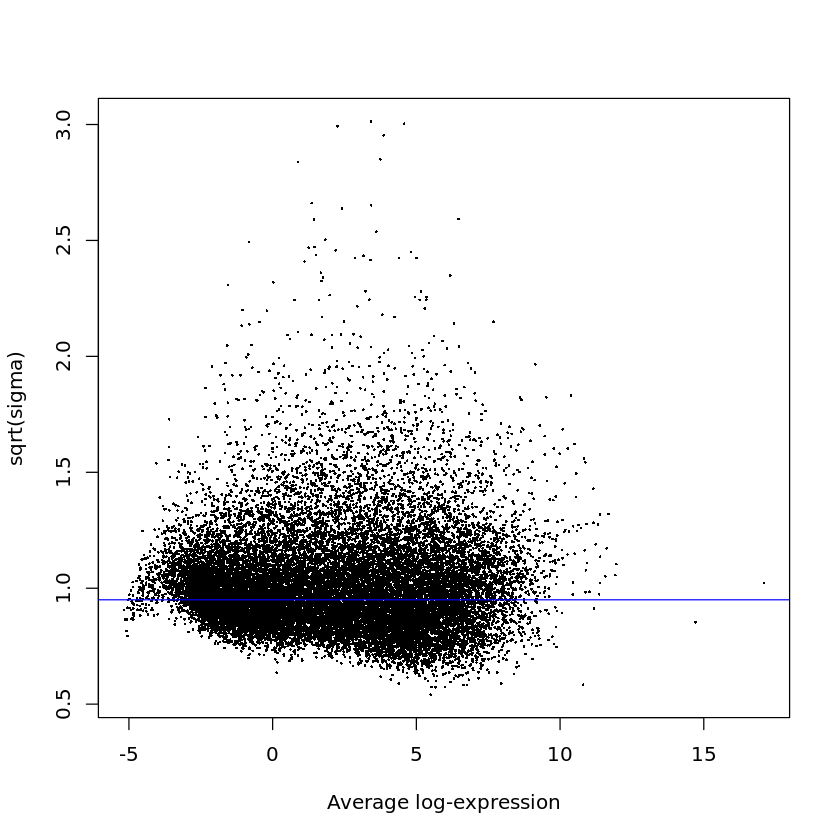

In [153]:
plotSA(efit)

In [154]:
#summary of differential expression results
summary(decideTests(efit))

       Case_vs_Control
Down                12
NotSig           23249
Up                   2

In [155]:
DE.results <- as.data.frame(summary(decideTests(efit))) %>%
pivot_wider(names_from = Var2, values_from = Freq)

In [156]:
DE.results

Var1,Case_vs_Control
<fct>,<dbl>
Down,12
NotSig,23249
Up,2


In [157]:
#make table of mean CPM for each group to add to results file
control.Group <- sample_meta.sub$sample_id[sample_meta.sub$Cognition_phenotype == "PDnoCI"]
case.Group <- sample_meta.sub$sample_id[sample_meta.sub$Cognition_phenotype == "PDD"]

In [158]:
controlCPM <- logCPM[,control.Group]
caseCPM <- logCPM[,case.Group]

In [159]:
meanCPM <- data.frame("gene_id" = row.names(logCPM),
                      "AvgExpr_Control" = rowMeans(controlCPM),
                      "AvgExpr_Case" = rowMeans(caseCPM)

)
summary(meanCPM)

   gene_id          AvgExpr_Control    AvgExpr_Case    
 Length:23263       Min.   :-2.9245   Min.   :-3.0738  
 Class :character   1st Qu.:-0.4268   1st Qu.:-0.3845  
 Mode  :character   Median : 2.0700   Median : 2.1002  
                    Mean   : 2.2665   Mean   : 2.2284  
                    3rd Qu.: 4.6900   3rd Qu.: 4.6058  
                    Max.   :17.0964   Max.   :17.0580  

In [160]:
head(meanCPM)

,gene_id,AvgExpr_Control,AvgExpr_Case
,<chr>,<dbl>,<dbl>
ENSG00000280143.1,ENSG00000280143.1,-1.2977435,-1.8845693
ENSG00000269416.5,ENSG00000269416.5,-2.6146769,-2.7542023
ENSG00000263642.1,ENSG00000263642.1,0.2281337,0.7416777
ENSG00000198242.13,ENSG00000198242.13,8.6600655,8.2623314
ENSG00000231981.3,ENSG00000231981.3,0.2844709,0.2830190
ENSG00000134108.12,ENSG00000134108.12,5.7583738,5.2929464


In [161]:
#Classify a series of related t-statistics as up, down or not significant
dt <- decideTests(efit)

In [162]:
#output full results table with logFC, p values, and mean CPM for each gene
df <- topTable(efit, coef = 1, n = Inf)

In [163]:
df.withMeans <- left_join(df, meanCPM)

Joining with `by = join_by(gene_id)`


In [164]:
df.withMeans$minus_log10_pValue <- -log10(df.withMeans$P.Value)

In [165]:
head(df.withMeans)

,X,gene_id,gene_name,gene_type,seqname,start,end,strand,logFC,AveExpr,t,P.Value,adj.P.Val,B,AvgExpr_Control,AvgExpr_Case,minus_log10_pValue
,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2705958,ENSG00000102024.17,PLS3,protein_coding,chrX,115561174,115650861,+,-3.388923,-1.24385853,-5.919555,2.962222e-07,0.006891017,4.880868,-0.8203175,-3.0737653,6.528382
2,750985,ENSG00000270558.1,AC025449.1,processed_pseudogene,chr5,37286449,37286977,-,-1.563424,-0.44404056,-5.285480,2.784043e-06,0.032382597,4.089878,-0.2161641,-1.4621504,5.555324
3,1853421,ENSG00000259066.5,AL110118.2,protein_coding,chr14,93184973,93218586,+,-2.499502,-0.85731418,-5.069837,5.894265e-06,0.032619073,3.111669,-0.5258121,-2.5335146,5.229570
4,2701191,ENSG00000198088.10,NUP62CL,protein_coding,chrX,107123427,107206433,-,-2.395341,-0.03503932,-4.921902,9.815308e-06,0.032619073,2.983913,0.2116636,-2.1132514,5.008096
5,743062,ENSG00000248150.1,LINC02150,lincRNA,chr5,16373361,16440081,-,1.907746,-0.85472528,4.881962,1.125616e-05,0.032731499,2.971522,-0.6598600,0.7088294,4.948610
6,1666461,ENSG00000221949.5,LINC01465,lincRNA,chr12,62601751,62603690,-,-2.110910,-0.85432699,-4.937189,9.313206e-06,0.032619073,2.881270,-0.5566788,-1.6087915,5.030901


In [166]:
library(ggrepel)

In [167]:
genes<-subset(df.withMeans,((adj.P.Val<0.05 & logFC>=log2(1.5)) | (adj.P.Val<0.05 & logFC<=-log2(1.5))))

In [168]:
genes

,X,gene_id,gene_name,gene_type,seqname,start,end,strand,logFC,AveExpr,t,P.Value,adj.P.Val,B,AvgExpr_Control,AvgExpr_Case,minus_log10_pValue
,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2705958,ENSG00000102024.17,PLS3,protein_coding,chrX,115561174,115650861,+,-3.388923,-1.24385853,-5.919555,2.962222e-07,0.006891017,4.880868,-0.8203175,-3.0737653,6.528382
2,750985,ENSG00000270558.1,AC025449.1,processed_pseudogene,chr5,37286449,37286977,-,-1.563424,-0.44404056,-5.285480,2.784043e-06,0.032382597,4.089878,-0.2161641,-1.4621504,5.555324
3,1853421,ENSG00000259066.5,AL110118.2,protein_coding,chr14,93184973,93218586,+,-2.499502,-0.85731418,-5.069837,5.894265e-06,0.032619073,3.111669,-0.5258121,-2.5335146,5.229570
4,2701191,ENSG00000198088.10,NUP62CL,protein_coding,chrX,107123427,107206433,-,-2.395341,-0.03503932,-4.921902,9.815308e-06,0.032619073,2.983913,0.2116636,-2.1132514,5.008096
5,743062,ENSG00000248150.1,LINC02150,lincRNA,chr5,16373361,16440081,-,1.907746,-0.85472528,4.881962,1.125616e-05,0.032731499,2.971522,-0.6598600,0.7088294,4.948610
6,1666461,ENSG00000221949.5,LINC01465,lincRNA,chr12,62601751,62603690,-,-2.110910,-0.85432699,-4.937189,9.313206e-06,0.032619073,2.881270,-0.5566788,-1.6087915,5.030901
7,933342,ENSG00000199630.1,RF00019,misc_RNA,chr6,89841329,89841424,+,-2.692947,-1.03758636,-4.980005,8.037606e-06,0.032619073,2.861270,-0.6721558,-2.3647631,5.094873
8,899459,ENSG00000226976.3,COX6A1P2,processed_pseudogene,chr6,37044860,37045189,+,-2.523766,-1.79734388,-5.060195,6.094208e-06,0.032619073,2.619413,-1.2830542,-3.0737653,5.215083
9,1719633,ENSG00000139714.12,MORN3,protein_coding,chr12,121648742,121672631,-,1.350504,2.27543668,4.648392,2.491040e-05,0.041392193,2.499265,2.2617557,3.3471046,4.603619


In [169]:
df <- df %>% 
  mutate(
    Expression = case_when(logFC >= log2(1.5) & adj.P.Val <= 0.05 ~ "Up-regulated",
                           logFC <= -log2(1.5) & adj.P.Val <= 0.05 ~ "Down-regulated",
                           TRUE ~ "Unchanged")
    )

In [170]:
p2 <- ggplot(df, aes(logFC, -log(adj.P.Val,10))) +
  geom_point(aes(color = Expression), size = 1) +
  xlab(expression("log"[2]*"FC")) + 
  ylab(expression("-log"[10]*"(padj)")) +
  scale_color_manual(values = c("dodgerblue3", "gray50", "firebrick3")) +
  guides(colour = guide_legend(override.aes = list(size=1.5)))+
  geom_hline(yintercept = -log10(0.05),linetype = "dashed") + 
  geom_vline(xintercept = c(-log2(1.5), log2(1.5)),linetype = "dashed") +
  geom_text_repel(data = genes, 
                  aes(label = gene_name))

Warning message:
“ggrepel: 5 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


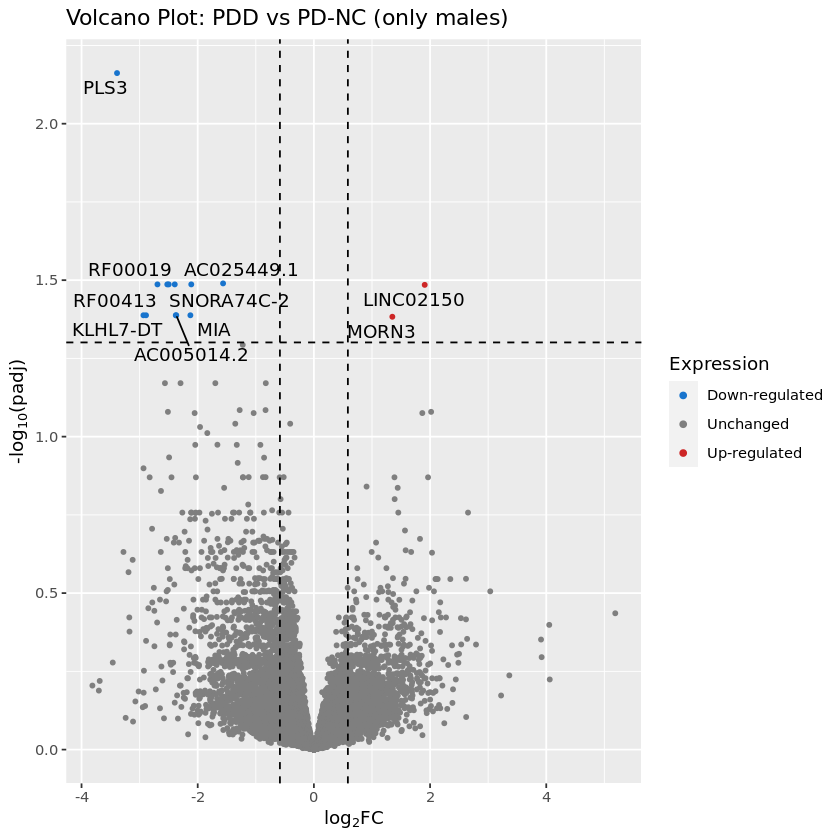

In [188]:
p2 + ggtitle("Volcano Plot: PDD vs PD-NC (only males)")
#linea horizontal log fold change
#linea vertical -log10 p value

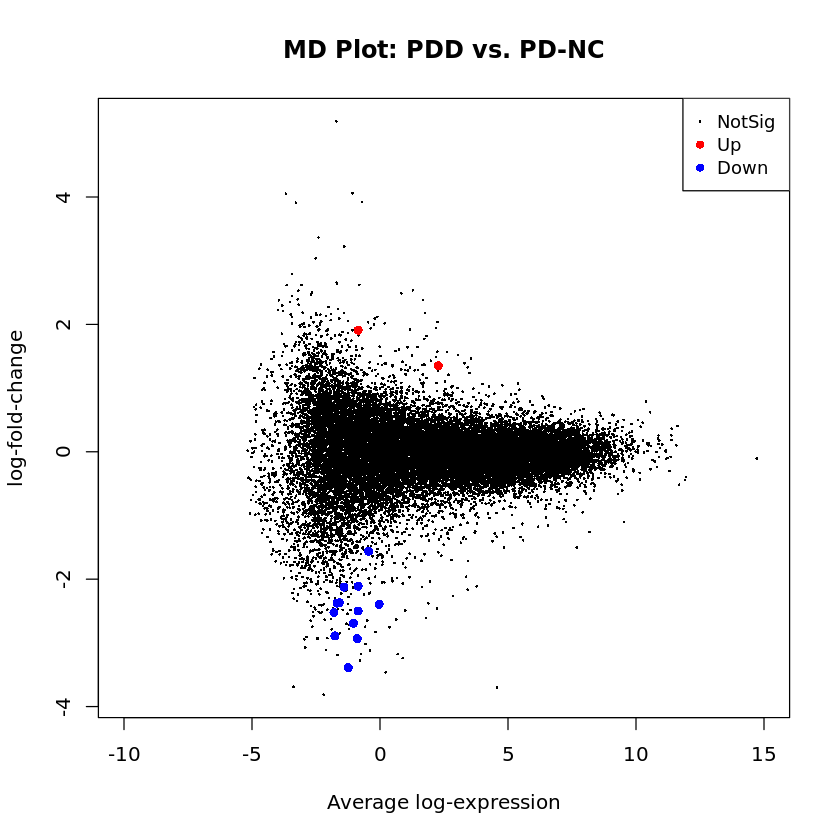

In [172]:
#MD plot with upregulated genes in green and downregulated genes in red
plotMD(efit, column = 1, status = dt[,1], main = "MD Plot: PDD vs. PD-NC",
       xlim=c(-10,15))

In [173]:
write_tsv(df.withMeans, "PDD_vs_PDnoCI_M0_passingFilt_white_limmaResults.tsv")

In [174]:
system(paste0("gsutil cp ./* ",WORKSPACE_BUCKET),intern=TRUE)

character(0)

In [175]:
#df.withMeans
df.withMeansPath <- file.path({WORKSPACE_BUCKET}, 'PDD_vs_PDnoCI_M0_passingFilt_white_limmaResults.tsv')
tmp <- gcs_read_file(df.withMeansPath)
df.withMeans <- read.csv(tmp,header=TRUE, sep="\t")

In [176]:
df.withMeans

X,gene_id,gene_name,gene_type,seqname,start,end,strand,logFC,AveExpr,t,P.Value,adj.P.Val,B,AvgExpr_Control,AvgExpr_Case,minus_log10_pValue
<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2705958,ENSG00000102024.17,PLS3,protein_coding,chrX,115561174,115650861,+,-3.3889232,-1.24385853,-5.919555,2.962222e-07,0.006891017,4.8808682,-0.82031750,-3.0737653,6.528382
750985,ENSG00000270558.1,AC025449.1,processed_pseudogene,chr5,37286449,37286977,-,-1.5634244,-0.44404056,-5.285480,2.784043e-06,0.032382597,4.0898778,-0.21616411,-1.4621504,5.555324
1853421,ENSG00000259066.5,AL110118.2,protein_coding,chr14,93184973,93218586,+,-2.4995018,-0.85731418,-5.069837,5.894265e-06,0.032619073,3.1116685,-0.52581213,-2.5335146,5.229570
2701191,ENSG00000198088.10,NUP62CL,protein_coding,chrX,107123427,107206433,-,-2.3953414,-0.03503932,-4.921902,9.815308e-06,0.032619073,2.9839127,0.21166362,-2.1132514,5.008096
743062,ENSG00000248150.1,LINC02150,lincRNA,chr5,16373361,16440081,-,1.9077463,-0.85472528,4.881962,1.125616e-05,0.032731499,2.9715220,-0.65986000,0.7088294,4.948610
1666461,ENSG00000221949.5,LINC01465,lincRNA,chr12,62601751,62603690,-,-2.1109096,-0.85432699,-4.937189,9.313206e-06,0.032619073,2.8812698,-0.55667876,-1.6087915,5.030901
933342,ENSG00000199630.1,RF00019,misc_RNA,chr6,89841329,89841424,+,-2.6929473,-1.03758636,-4.980005,8.037606e-06,0.032619073,2.8612699,-0.67215584,-2.3647631,5.094873
899459,ENSG00000226976.3,COX6A1P2,processed_pseudogene,chr6,37044860,37045189,+,-2.5237665,-1.79734388,-5.060195,6.094208e-06,0.032619073,2.6194129,-1.28305420,-3.0737653,5.215083
1719633,ENSG00000139714.12,MORN3,protein_coding,chr12,121648742,121672631,-,1.3505044,2.27543668,4.648392,2.491040e-05,0.041392193,2.4992654,2.26175574,3.3471046,4.603619


In [177]:
genes<-subset(df.withMeans,((adj.P.Val<=0.05 & logFC>=log2(1.5)) | (adj.P.Val<=0.05 & logFC<=-log2(1.5))),select="gene_name")
genes

,gene_name
,<chr>
1,PLS3
2,AC025449.1
3,AL110118.2
4,NUP62CL
5,LINC02150
6,LINC01465
7,RF00019
8,COX6A1P2
9,MORN3


In [178]:
library(goseq)
library(org.Hs.eg.db)
library(GO.db)

In [179]:
genes<-subset(df.withMeans,((adj.P.Val<=0.05 & logFC>=log2(1.5)) | (adj.P.Val<=0.05 & logFC<=-log2(1.5))),select="gene_id")
genes$gene_id <- sub("\\..*", "", genes$gene_id)
genes<-genes$gene_id

In [180]:
genes

[1] "ENSG00000102024" "ENSG00000270558" "ENSG00000259066" "ENSG00000198088"
 [5] "ENSG00000248150" "ENSG00000221949" "ENSG00000199630" "ENSG00000226976"
 [9] "ENSG00000139714" "ENSG00000230658" "ENSG00000272361" "ENSG00000261857"
[13] "ENSG00000223111" "ENSG00000222588"

In [181]:
library(clusterProfiler)
library(ggplot2)

In [182]:
sample_test <- enrichGO(genes, OrgDb=org.Hs.eg.db, pAdjustMethod = "BH", pvalueCutoff  = 0.01, qvalueCutoff  = 0.05,keyType = "ENSEMBL",ont="BP")

ont= MP (molecular process), BP (biological process), MF (molecular function, in what process is involved?)

In [183]:
sample_test

#
# over-representation test
#
#...@organism 	 Homo sapiens 
#...@ontology 	 BP 
#...@keytype 	 ENSEMBL 
#...@gene 	 chr [1:14] "ENSG00000102024" "ENSG00000270558" "ENSG00000259066" ...
#...pvalues adjusted by 'BH' with cutoff <0.01 
#...0 enriched terms found
#...Citation
 T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu.
 clusterProfiler 4.0: A universal enrichment tool for interpreting omics data.
 The Innovation. 2021, 2(3):100141 


In [184]:
enrich_go_tidy <- sample_test %>% 
  slot("result") %>% 
  tibble::as.tibble() 
enrich_go_tidy

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0051639,actin filament network formation,1/3,12/21069,0.00170778,0.03586337,0.01258364,ENSG00000102024,1
GO:0006405,RNA export from nucleus,1/3,97/21069,0.01374892,0.05513030,0.01934396,ENSG00000198088,1
GO:0006606,protein import into nucleus,1/3,175/21069,0.02471289,0.05513030,0.01934396,ENSG00000198088,1
GO:0051017,actin filament bundle assembly,1/3,175/21069,0.02471289,0.05513030,0.01934396,ENSG00000102024,1
GO:0051170,import into nucleus,1/3,179/21069,0.02527295,0.05513030,0.01934396,ENSG00000198088,1
GO:0061572,actin filament bundle organization,1/3,179/21069,0.02527295,0.05513030,0.01934396,ENSG00000102024,1
GO:0050657,nucleic acid transport,1/3,183/21069,0.02583278,0.05513030,0.01934396,ENSG00000198088,1
GO:0050658,RNA transport,1/3,183/21069,0.02583278,0.05513030,0.01934396,ENSG00000198088,1
GO:0051168,nuclear export,1/3,184/21069,0.02597271,0.05513030,0.01934396,ENSG00000198088,1


In [185]:
dotplot(sample_test,font.size = 8)

Warning message in rep(yes, length.out = len):
“'x' is NULL so the result will be NULL”
ERROR while rich displaying an object: Error in ans[ypos] <- rep(yes, length.out = len)[ypos]: replacement has length zero

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr

In [186]:
library(enrichplot)

In [187]:
par(mfrow=c(5,5))
goplot(sample_test,font.size=5)

ERROR: Error in .checkKeysAreWellFormed(keys): keys must be supplied in a character vector with no NAs


In [ ]:
sample_test